In [9]:
# Automatically analyze particle size from photos
#https://qiita.com/kon2/items/a0c4fbf9bb2063e9fb0e

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import copy
import scipy.ndimage as ndimage
import cv2


In [11]:
#data load
df_path="temp/df.bin"
df=joblib.load(df_path)

In [12]:
processed_df=copy.copy(df)

In [13]:
#list(processed_df.columns)

In [14]:

def count_particles(path,threshold=16,write_image=True,mag=3,um_to_pixel=37.8):
    """
    path :str
        path to the image
    threshold: int
        threshold to detect particles
    write_image: bool
        if true, write image with contours
    mag: int
        magnify image for more precise analyses
    um_to_pixel: float
        constant (1 micron meter corresponds to {un_to_pixel} pixel)
 
    returns
    
    eq_diameters: np array of float
        diameters of the particles
    
    """
    
    img_raw = cv2.imread(path, 1)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2GRAY)

    #height and weight
    h, w = img.shape

    #magnify image
    img = cv2.resize(img, (w*mag, h*mag))

    #gauss blur
    img_blur = cv2.GaussianBlur(img,(5,5),0)

    #to binary
    threshold=cv2.THRESH_BINARY+cv2.THRESH_OTSU
    ret,th = cv2.threshold(img_blur,0,255,threshold)

    #get threshold
    kernel = np.ones((3,3),np.uint8)
    th = cv2.dilate(th,kernel,iterations = 1)

    #to binary
    th_fill = ndimage.binary_fill_holes(th).astype(int) * 255

    #add contours to theimage
    cnt,_ = cv2.findContours(th.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img_raw_ = cv2.resize(img_raw, (w*mag, h*mag))
    img_cnt = cv2.drawContours(img_raw_, cnt, -1, (255,0,255), 5)

    img_cnt_save = cv2.resize(img_cnt, dsize=None, fx=0.2, fy=0.2)
    
    if write_image:
        path_components=path.split(".")
        new_path=path_components[0]+"_contour."+path_components[1]
        cv2.imwrite(new_path, img_cnt_save)


    eq_diameters = []

    for i in cnt:
        area = cv2.contourArea(i)

        #calc diameter
        eq_diameter = np.sqrt(4*area/np.pi)
        eq_diameters.append(eq_diameter)
        
    eq_diameters=sorted(eq_diameters)
    
    #largest one should not be particle
    eq_diameters=eq_diameters[:-1]
    return np.array(eq_diameters)/um_to_pixel

def auto_parse(path):
    print(path)
    eq_diameters=count_particles(path)    

    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams["font.size"] = 20
    

    plt.figure()
    bins = 10**(np.arange(0,3,0.1))
    plt.hist(np.array(eq_diameters), bins=bins, rwidth=0.7)
    plt.xscale('log')
    plt.xlabel("Equal diameters ($\mu$m)")
    plt.ylabel("Frequency")
    plt.tick_params(width = 1, length = 10)
    

    median=np.median(eq_diameters)
    std=np.std(eq_diameters)
    d10=calc_dX(eq_diameters,10)
    d90=calc_dX(eq_diameters,90)
    
    
    return (median,std,d10,d90)


def calc_dX(eq_diameters,x):

    eq_diameters=sorted(list(eq_diameters))
    num_records=len(eq_diameters)
    pos=int(num_records*x/100)
    
    return eq_diameters[pos]


normal_experiment31_graph_integrated_json_0_database/experiments/HA/exp220_particle_analyses/ball_mill.graphml
database/experiments/HA/exp220_particle_analyses/photos/1.jpg
normal_experiment31_graph_integrated_json_1_database/experiments/HA/exp220_particle_analyses/ball_mill.graphml
database/experiments/HA/exp220_particle_analyses/photos/5.jpg
normal_experiment31_graph_integrated_json_2_database/experiments/HA/exp220_particle_analyses/ball_mill.graphml
database/experiments/HA/exp220_particle_analyses/photos/15.jpg
normal_experiment31_graph_integrated_json_3_database/experiments/HA/exp220_particle_analyses/ball_mill.graphml
database/experiments/HA/exp220_particle_analyses/photos/30.jpg
normal_experiment31_graph_integrated_json_4_database/experiments/HA/exp220_particle_analyses/ball_mill.graphml
database/experiments/HA/exp220_particle_analyses/photos/60.jpg
normal_experiment31_graph_integrated_json_5_database/experiments/HA/exp220_particle_analyses/ball_mill.graphml
database/experiments/

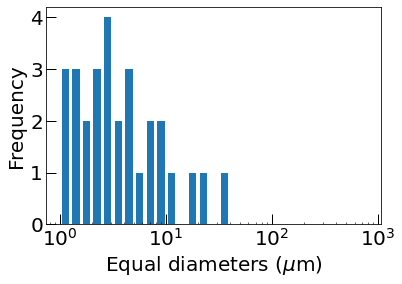

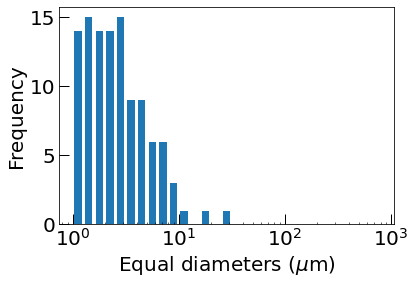

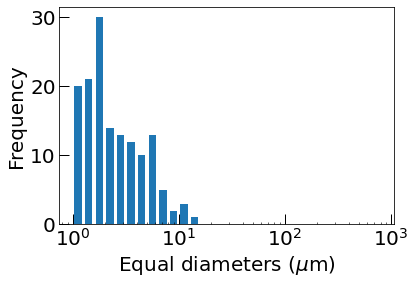

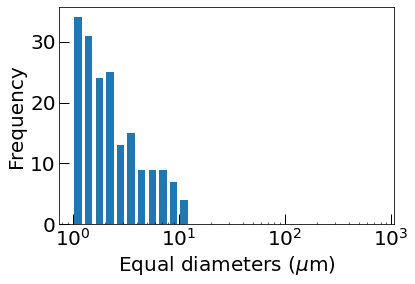

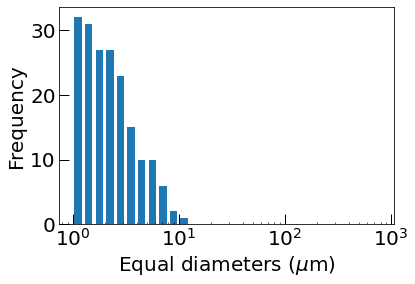

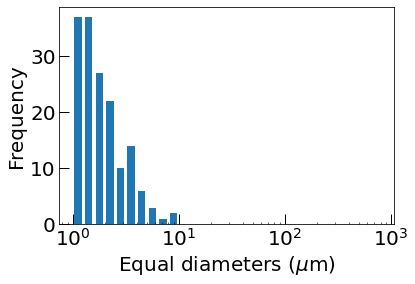

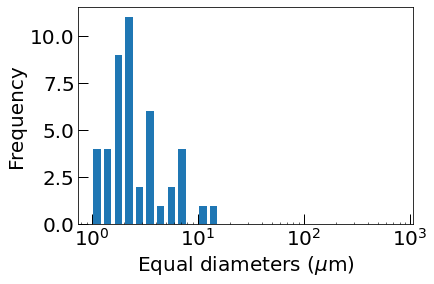

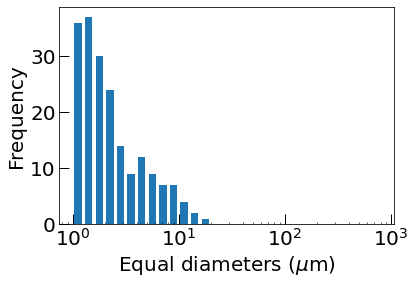

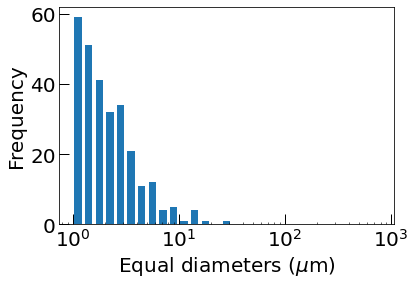

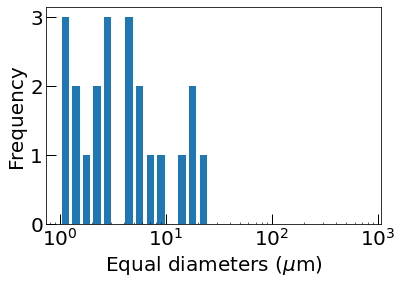

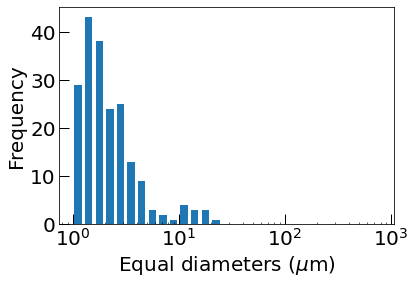

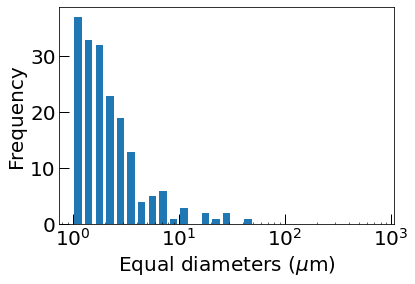

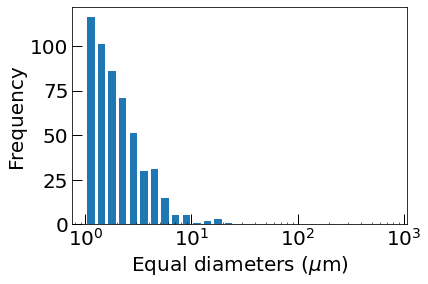

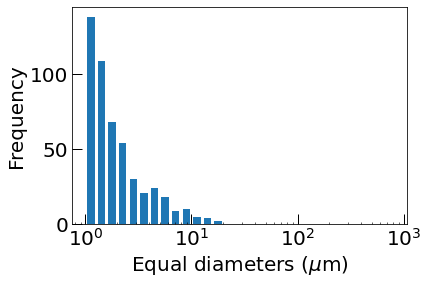

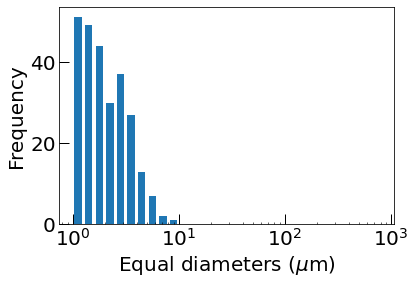

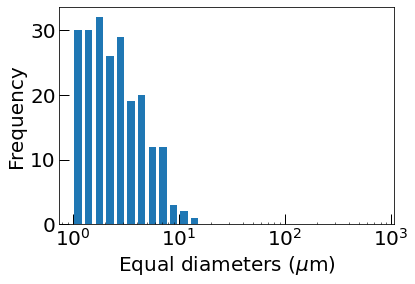

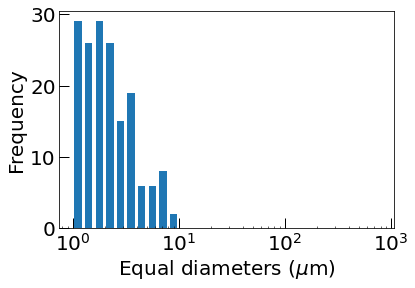

In [15]:
target_label="particle_size_load_data"

particle_dict={}


for i in range(processed_df.shape[0]):
    
    if not processed_df[target_label][i]==processed_df[target_label][i]:
        continue

    ind=processed_df.index[i]

    print(ind)
    
    parsed_dict={}
    data_path=processed_df[target_label][i]
    
    med,std,d10,d90=auto_parse(data_path)
    parsed_dict["$d_{50}$ ($\mu$m)"]=med
    parsed_dict["$d_\mathrm{std}$ ($\mu$m)"]=std
    #parsed_dict["$d_{10}$ ($\mu$m)"]=d10
    #parsed_dict["$d_{90}$ ($\mu$m)"]=d90
    particle_dict[ind]=parsed_dict
    

In [16]:
joblib.dump(particle_dict,"temp/parsed/particle_anal.bin")

['temp/parsed/particle_anal.bin']